## Imports

In [ ]:
!pip install efficientnet --upgrade -q
!pip install segmentation_models -q --upgrade

In [2]:
import os
import cv2
import glob
import shutil
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import segmentation_models as sm
import efficientnet.tfkeras as efn
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

from tqdm.notebook import tqdm
from sklearn.model_selection import KFold

import warnings
warnings.simplefilter('ignore')

Segmentation Models: using `keras` framework.


## Conifg

In [3]:
sm.set_framework('tf.keras')
sm.framework()
os.environ['SM_FRAMEWORK'] = 'tf.keras'

class Config:
  
  gcs_path = 'gs://kds-a73771649e903d014193a8922ad9a9e622325a9f3af3c4949402f828'
  SEED = 1234

  AUTO = tf.data.experimental.AUTOTUNE

  n_folds = 5
  img_size = [256, 256]
  batch_size = 128

  backbone = 'efficientnetb7'
  epochs = 20
  lr = 1e-4

config = Config()

In [4]:
try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError: # no TPU found, detect GPUs
    #strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Initializing the TPU system: grpc://10.106.181.10:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.106.181.10:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Number of accelerators:  8


## GCS_PATHS

In [5]:
ALL_TRAINING_FILENAMES = tf.io.gfile.glob(config.gcs_path + '/train/*')
ALL_TRAINING_FILENAMES

['gs://kds-a73771649e903d014193a8922ad9a9e622325a9f3af3c4949402f828/train/0486052bb-355.tfrec',
 'gs://kds-a73771649e903d014193a8922ad9a9e622325a9f3af3c4949402f828/train/095bf7a1f-656.tfrec',
 'gs://kds-a73771649e903d014193a8922ad9a9e622325a9f3af3c4949402f828/train/1e2425f28-586.tfrec',
 'gs://kds-a73771649e903d014193a8922ad9a9e622325a9f3af3c4949402f828/train/26dc41664-794.tfrec',
 'gs://kds-a73771649e903d014193a8922ad9a9e622325a9f3af3c4949402f828/train/2f6ecfcdf-324.tfrec',
 'gs://kds-a73771649e903d014193a8922ad9a9e622325a9f3af3c4949402f828/train/4ef6695ce-1220.tfrec',
 'gs://kds-a73771649e903d014193a8922ad9a9e622325a9f3af3c4949402f828/train/54f2eec69-299.tfrec',
 'gs://kds-a73771649e903d014193a8922ad9a9e622325a9f3af3c4949402f828/train/8242609fa-770.tfrec',
 'gs://kds-a73771649e903d014193a8922ad9a9e622325a9f3af3c4949402f828/train/aaa6a05cc-134.tfrec',
 'gs://kds-a73771649e903d014193a8922ad9a9e622325a9f3af3c4949402f828/train/afa5e8098-1125.tfrec',
 'gs://kds-a73771649e903d014193a8922ad

In [6]:
import re
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)
print('NUM_TRAINING_IMAGES:' )
print(count_data_items(ALL_TRAINING_FILENAMES))

NUM_TRAINING_IMAGES:
9580


## Creating Folds

In [7]:
ALL_TRAINING_FILENAMES = np.array(ALL_TRAINING_FILENAMES)

splitter = KFold(n_splits=5, random_state=config.SEED)

train_files = []
valid_files = []

for fold, (trn_, val_) in enumerate(splitter.split(range(len(ALL_TRAINING_FILENAMES)))):
  fold_train_files = ALL_TRAINING_FILENAMES[trn_]
  fold_valid_files = ALL_TRAINING_FILENAMES[val_]
  np.random.shuffle(fold_train_files)
  train_files.append(fold_train_files)
  valid_files.append(fold_valid_files)

## Datasets pipeline

In [8]:
DIM = config.img_size[0]
def _parse_image_function(example_proto,augment = True):
    image_feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'mask': tf.io.FixedLenFeature([], tf.string)
    }
    single_example = tf.io.parse_single_example(example_proto, image_feature_description)
    image = tf.reshape(tf.io.decode_raw(single_example['image'],out_type=np.dtype('uint8')), (DIM,DIM, 3))
    mask =  tf.reshape(tf.io.decode_raw(single_example['mask'],out_type='bool'), (DIM,DIM,1))
    
    if augment:

        if tf.random.uniform(()) > 0.5:
            image = tf.image.flip_left_right(image)
            mask = tf.image.flip_left_right(mask)

        if tf.random.uniform(()) > 0.4:
            image = tf.image.flip_up_down(image)
            mask = tf.image.flip_up_down(mask)

        if tf.random.uniform(()) > 0.5:
            image = tf.image.rot90(image, k=1)
            mask = tf.image.rot90(mask, k=1)

        if tf.random.uniform(()) > 0.45:
            image = tf.image.random_saturation(image, 0.7, 1.3)

        if tf.random.uniform(()) > 0.45:
            image = tf.image.random_contrast(image, 0.8, 1.2)
    
    return tf.cast(image, tf.float32), tf.cast(mask, tf.float32)

def load_dataset(filenames, ordered=False, augment = True):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=config.AUTO)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(lambda ex: _parse_image_function(ex, augment = augment), num_parallel_calls=config.AUTO)
    return dataset

def get_training_dataset(TRAINING_FILENAMES):
    dataset = load_dataset(TRAINING_FILENAMES)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(128, seed = config.SEED)
    dataset = dataset.batch(config.batch_size,drop_remainder=True)
    dataset = dataset.prefetch(config.AUTO)
    return dataset

def get_validation_dataset(VALIDATION_FILENAMES, ordered=True):
    dataset = load_dataset(VALIDATION_FILENAMES, ordered=ordered, augment = False)
    dataset = dataset.batch(config.batch_size,drop_remainder=True)
    dataset = dataset.prefetch(config.AUTO)
    return dataset

In [9]:
ds = get_training_dataset(train_files[0])

In [10]:
for i in ds:
  print(i[0].shape, i[1].shape)
  break

(128, 256, 256, 3) (128, 256, 256, 1)


## Metrics

In [11]:
# https://tensorlayer.readthedocs.io/en/latest/_modules/tensorlayer/cost.html#dice_coe
def dice_coe(output, target, axis = None, smooth=1e-10):
    output = tf.dtypes.cast( tf.math.greater(output, 0.5), tf. float32 )
    target = tf.dtypes.cast( tf.math.greater(target, 0.5), tf. float32 )
    inse = tf.reduce_sum(output * target, axis=axis)
    l = tf.reduce_sum(output, axis=axis)
    r = tf.reduce_sum(target, axis=axis)

    dice = (2. * inse + smooth) / (l + r + smooth)
    dice = tf.reduce_mean(dice, name='dice_coe')
    return dice

# https://www.kaggle.com/kool777/training-hubmap-eda-tf-keras-tpu
def tversky(y_true, y_pred, alpha=0.7, beta=0.3, smooth=1):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    return (true_pos + smooth) / (true_pos + alpha * false_neg + beta * false_pos + smooth)
def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true, y_pred)
def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    tv = tversky(y_true, y_pred)
    return K.pow((1 - tv), gamma)

get_custom_objects().update({"focal_tversky": focal_tversky_loss})

## Create Model

In [12]:
def get_model():
  model = sm.FPN(config.backbone, encoder_weights='imagenet', classes=1, activation='sigmoid')
  model.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.00005),
                loss = sm.losses.bce_dice_loss,
                metrics=[dice_coe,'accuracy', sm.metrics.iou_score])
  return model

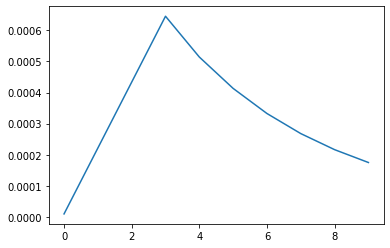

In [13]:
# Lr function
lr_start = 0.000005
lr_min = 0.00001
lr_max = 0.00000125 * 8 * 64
lr_decay = 0.8
lr_rampup = 3

def lrfn(epoch):
  if epoch <= lr_rampup:
    lr = (lr_max - lr_start)/lr_rampup * epoch + lr_min
  else:
    lr = (lr_max - lr_min) * lr_decay**(epoch - lr_rampup) + lr_min
  return lr

values = [lrfn(i) for i in range(10)]
plt.plot(values)

## Run Fold function

In [14]:
def run_fold(fold, display_plot=True):
  tfiles = train_files[fold]
  vfiles = valid_files[fold]

  K.clear_session()
  with strategy.scope():
    model = get_model()

  checkpoint = tf.keras.callbacks.ModelCheckpoint('./model-fold-%i.h5'%fold,
                                 monitor='val_dice_coe',patience = 10,
                                 mode='max',save_best_only=True)
  
  early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_dice_coe',mode = 'max', patience=10, restore_best_weights=True)

  lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=0)

  print(f'Training Model Fold {fold+1}...')
  history = model.fit(
      get_training_dataset(tfiles),
      epochs = config.epochs,
      steps_per_epoch = 9580//config.batch_size,
      callbacks = [checkpoint, lr_callback, early_stop],
      validation_data = get_validation_dataset(vfiles)
  )

  if display_plot:        
        plt.figure(figsize=(15,5))
        n_e = np.arange(len(history.history['dice_coe']))
        plt.plot(n_e,history.history['dice_coe'],'-o',label='Train dice_coe',color='#ff7f0e')
        plt.plot(n_e,history.history['val_dice_coe'],'-o',label='Val dice_coe',color='#1f77b4')
        x = np.argmax( history.history['val_dice_coe'] ); y = np.max( history.history['val_dice_coe'] )
        xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x,y,s=200,color='#1f77b4'); plt.text(x-0.03*xdist,y-0.13*ydist,'max dice_coe\n%.2f'%y,size=14)
        plt.ylabel('dice_coe',size=14); plt.xlabel('Epoch',size=14)
        plt.legend(loc=2)
        plt2 = plt.gca().twinx()
        plt2.plot(n_e,history.history['loss'],'-o',label='Train Loss',color='#2ca02c')
        plt2.plot(n_e,history.history['val_loss'],'-o',label='Val Loss',color='#d62728')
        x = np.argmin( history.history['val_loss'] ); y = np.min( history.history['val_loss'] )
        ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x,y,s=200,color='#d62728'); plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
        plt.ylabel('Loss',size=14)
        plt.legend(loc=3)
        plt.show()

  return history, model

## Training the model

Training Model Fold 1...
Epoch 1/20
74/74 [==============================] - 247s 847ms/step - loss: 1.8066 - dice_coe: 0.0866 - accuracy: 0.4022 - iou_score: 0.0349 - val_loss: 2.7913 - val_dice_coe: 0.0929 - val_accuracy: 0.3957 - val_iou_score: 0.0427
Epoch 2/20
74/74 [==============================] - 43s 576ms/step - loss: 0.6900 - dice_coe: 0.7012 - accuracy: 0.9742 - iou_score: 0.2991 - val_loss: 0.5522 - val_dice_coe: 0.8212 - val_accuracy: 0.9879 - val_iou_score: 0.3922
Epoch 3/20
74/74 [==============================] - 43s 575ms/step - loss: 0.2356 - dice_coe: 0.8644 - accuracy: 0.9931 - iou_score: 0.6704 - val_loss: 0.2198 - val_dice_coe: 0.9080 - val_accuracy: 0.9938 - val_iou_score: 0.6975
Epoch 4/20
74/74 [==============================] - 43s 577ms/step - loss: 0.1470 - dice_coe: 0.8961 - accuracy: 0.9948 - iou_score: 0.7845 - val_loss: 0.1463 - val_dice_coe: 0.9081 - val_accuracy: 0.9939 - val_iou_score: 0.7940
Epoch 5/20
74/74 [==============================] - 43s 57

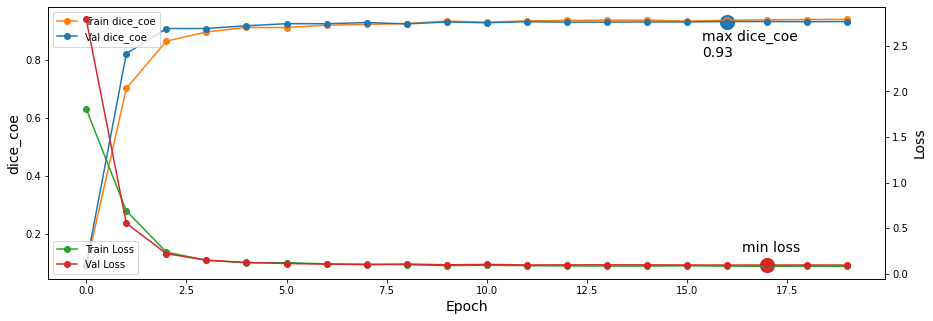

In [15]:
global_history = []
history, _ = run_fold(0)
global_history.append(history)0

Training Model Fold 2...
Epoch 1/20
74/74 [==============================] - 249s 852ms/step - loss: 1.6231 - dice_coe: 0.1260 - accuracy: 0.5844 - iou_score: 0.0412 - val_loss: 2.3844 - val_dice_coe: 0.0826 - val_accuracy: 0.5322 - val_iou_score: 0.0384
Epoch 2/20
74/74 [==============================] - 43s 587ms/step - loss: 0.6093 - dice_coe: 0.7234 - accuracy: 0.9801 - iou_score: 0.3588 - val_loss: 0.4953 - val_dice_coe: 0.7811 - val_accuracy: 0.9900 - val_iou_score: 0.4359
Epoch 3/20
74/74 [==============================] - 43s 586ms/step - loss: 0.2115 - dice_coe: 0.8633 - accuracy: 0.9931 - iou_score: 0.7059 - val_loss: 0.3626 - val_dice_coe: 0.8772 - val_accuracy: 0.9936 - val_iou_score: 0.5344
Epoch 4/20
74/74 [==============================] - 43s 587ms/step - loss: 0.1545 - dice_coe: 0.8864 - accuracy: 0.9945 - iou_score: 0.7798 - val_loss: 0.1866 - val_dice_coe: 0.9081 - val_accuracy: 0.9952 - val_iou_score: 0.7558
Epoch 5/20
74/74 [==============================] - 43s 58

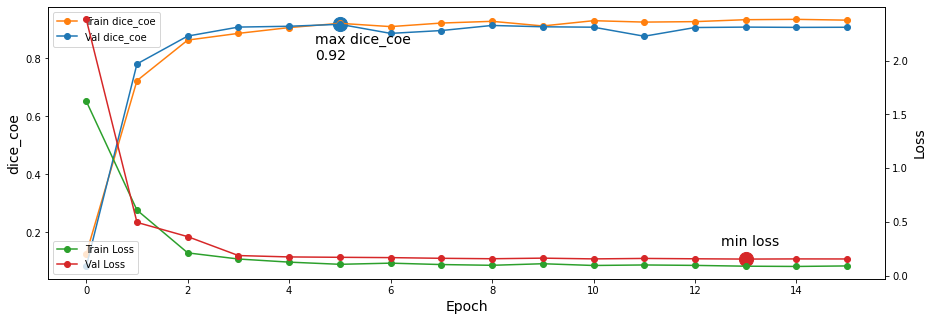

In [15]:
global_history = []
history, _ = run_fold(1)
global_history.append(history)

Training Model Fold 3...
Epoch 1/20
74/74 [==============================] - 249s 836ms/step - loss: 2.1398 - dice_coe: 0.0643 - accuracy: 0.1959 - iou_score: 0.0326 - val_loss: 3.8511 - val_dice_coe: 0.0822 - val_accuracy: 0.1641 - val_iou_score: 0.0423
Epoch 2/20
74/74 [==============================] - 42s 570ms/step - loss: 0.7988 - dice_coe: 0.6455 - accuracy: 0.9618 - iou_score: 0.2382 - val_loss: 0.5817 - val_dice_coe: 0.8203 - val_accuracy: 0.9857 - val_iou_score: 0.3571
Epoch 3/20
74/74 [==============================] - 42s 569ms/step - loss: 0.2687 - dice_coe: 0.8448 - accuracy: 0.9919 - iou_score: 0.6356 - val_loss: 0.3098 - val_dice_coe: 0.8869 - val_accuracy: 0.9918 - val_iou_score: 0.6007
Epoch 4/20
74/74 [==============================] - 42s 571ms/step - loss: 0.1575 - dice_coe: 0.8953 - accuracy: 0.9944 - iou_score: 0.7702 - val_loss: 0.1745 - val_dice_coe: 0.8966 - val_accuracy: 0.9922 - val_iou_score: 0.7645
Epoch 5/20
74/74 [==============================] - 42s 57

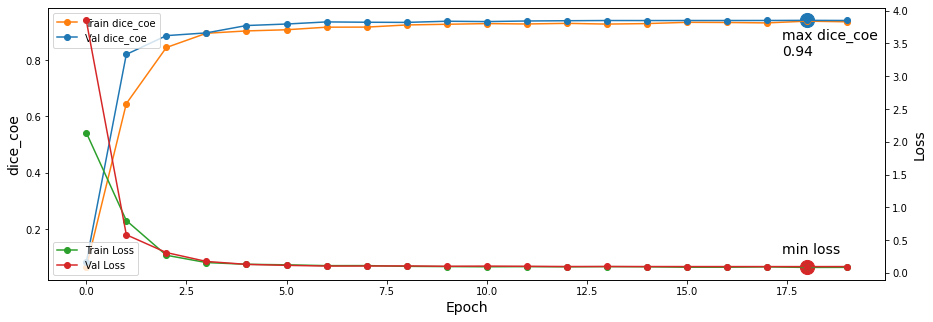

In [15]:
global_history = []
history, _ = run_fold(2)
global_history.append(history)

Training Model Fold 4...
Epoch 1/20
74/74 [==============================] - 250s 851ms/step - loss: 1.2840 - dice_coe: 0.2902 - accuracy: 0.8931 - iou_score: 0.0591 - val_loss: 2.3301 - val_dice_coe: 0.0641 - val_accuracy: 0.4744 - val_iou_score: 0.0322
Epoch 2/20
74/74 [==============================] - 43s 586ms/step - loss: 0.4292 - dice_coe: 0.7920 - accuracy: 0.9866 - iou_score: 0.4955 - val_loss: 0.4329 - val_dice_coe: 0.7770 - val_accuracy: 0.9919 - val_iou_score: 0.5062
Epoch 3/20
74/74 [==============================] - 43s 584ms/step - loss: 0.1711 - dice_coe: 0.8834 - accuracy: 0.9936 - iou_score: 0.7557 - val_loss: 0.3432 - val_dice_coe: 0.8703 - val_accuracy: 0.9940 - val_iou_score: 0.5958
Epoch 4/20
74/74 [==============================] - 43s 586ms/step - loss: 0.1381 - dice_coe: 0.8987 - accuracy: 0.9945 - iou_score: 0.8026 - val_loss: 0.3992 - val_dice_coe: 0.7865 - val_accuracy: 0.9915 - val_iou_score: 0.5239
Epoch 5/20
74/74 [==============================] - 43s 58

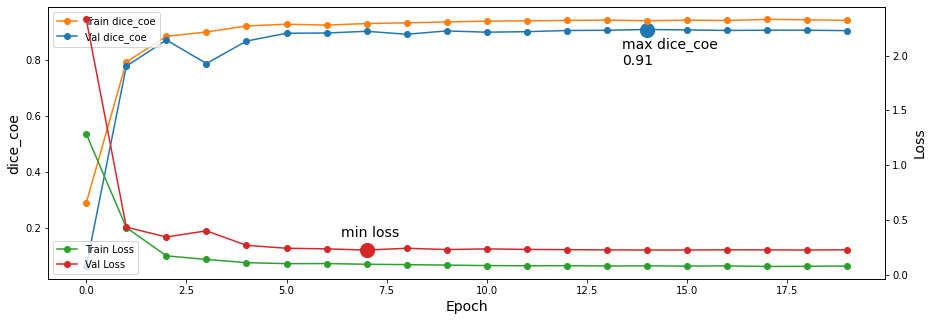

In [15]:
global_history = []
history, _ = run_fold(3)
global_history.append(history)

258441216/258434480 [==============================] - 4s 0us/step
Training Model Fold 5...
Epoch 1/20
74/74 [==============================] - 243s 845ms/step - loss: 1.3317 - dice_coe: 0.2379 - accuracy: 0.8591 - iou_score: 0.0556 - val_loss: 1.9725 - val_dice_coe: 0.0690 - val_accuracy: 0.5394 - val_iou_score: 0.0321
Epoch 2/20
74/74 [==============================] - 43s 583ms/step - loss: 0.4217 - dice_coe: 0.8051 - accuracy: 0.9864 - iou_score: 0.5048 - val_loss: 0.5252 - val_dice_coe: 0.6904 - val_accuracy: 0.9926 - val_iou_score: 0.3985
Epoch 3/20
74/74 [==============================] - 43s 584ms/step - loss: 0.1617 - dice_coe: 0.8924 - accuracy: 0.9935 - iou_score: 0.7673 - val_loss: 0.3585 - val_dice_coe: 0.7813 - val_accuracy: 0.9946 - val_iou_score: 0.5869
Epoch 4/20
74/74 [==============================] - 43s 585ms/step - loss: 0.1203 - dice_coe: 0.9135 - accuracy: 0.9949 - iou_score: 0.8225 - val_loss: 0.3176 - val_dice_coe: 0.8132 - val_accuracy: 0.9957 - val_iou_score

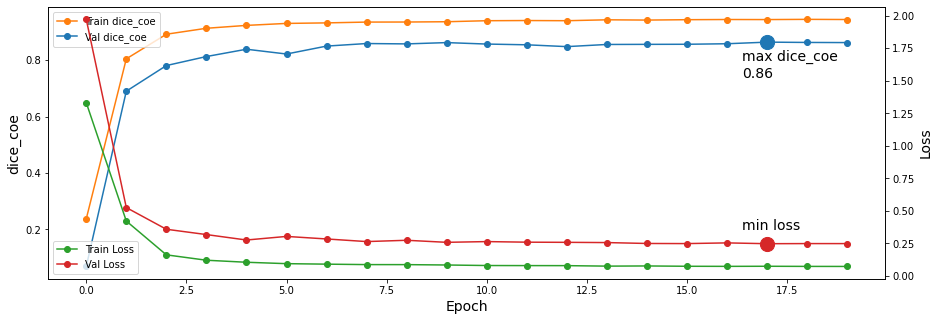

In [15]:
global_history = []
history, _ = run_fold(4)
global_history.append(history)

## OOF Results

In [17]:
dice_values = [0.9321, 0.9075, 0.9421, 0.9406, 0.8627]
np.mean(dice_values)

0.917